In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [17]:
def get_metrics(y_true, y_pred, num_classes=2, metrics='IoU', graph_for=-1):
    """calculate IOU for confidence map of an object"""
    v = 0
    for k in range(num_classes):
      t = y_true == k
      p = y_pred == k
      i = np.logical_and(t, p)

      if graph_for == k:
        _, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(t[0, :, :, 0], cmap='gray')
        ax[0].set_title('label')
        ax[1].imshow(p[0, :, :, 0], cmap='gray')
        ax[1].set_title('predict')
        ax[2].imshow(i[0, :, :, 0], cmap='hot')
        ax[2].set_title('intersection')

      i_sum = np.sum(i)
      t_sum = np.sum(t)
      p_sum = np.sum(p)

      if metrics == 'f1':
        v += 2 * i_sum / (t_sum + p_sum + 1e-7)
      elif metrics == 'IoU':
        u_sum = t_sum + p_sum - i_sum
        v += i_sum / (u_sum + 1e-7)
      else:
        raise Exception("Invalid metric")

    return v / num_classes

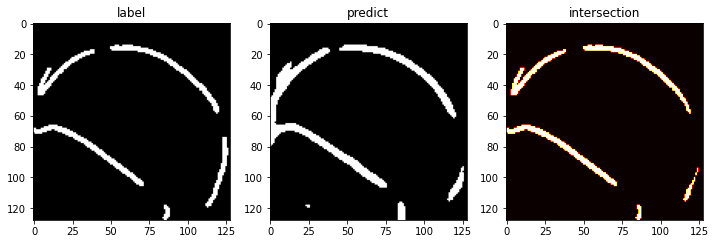

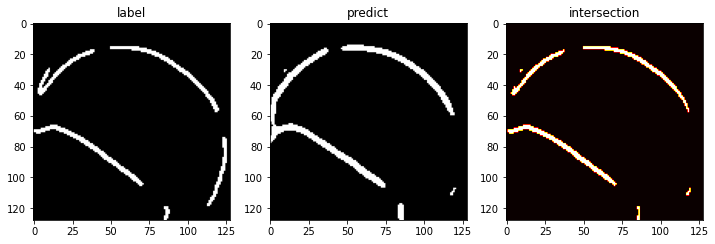

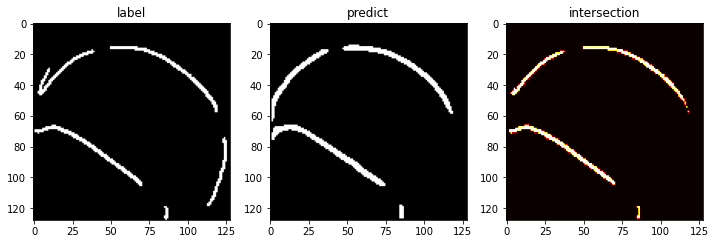

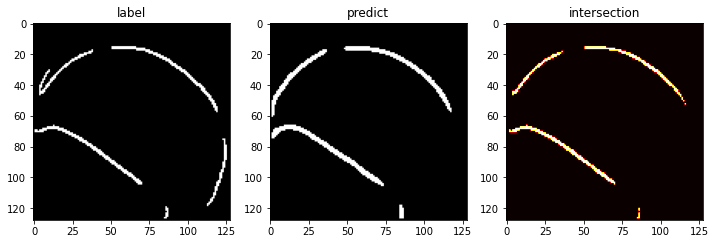

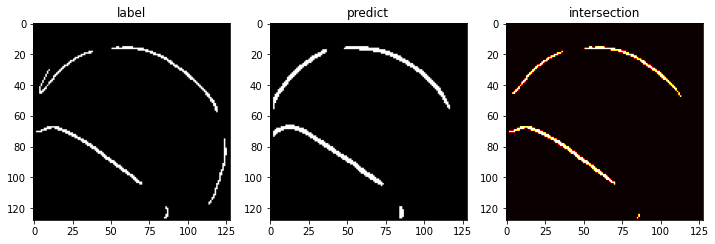

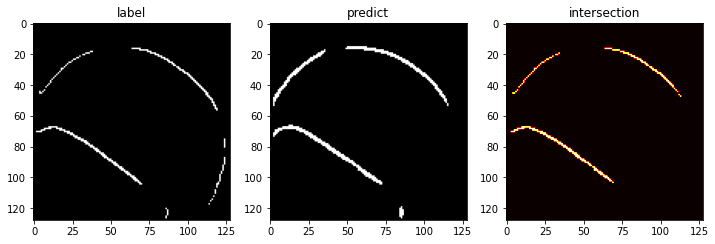

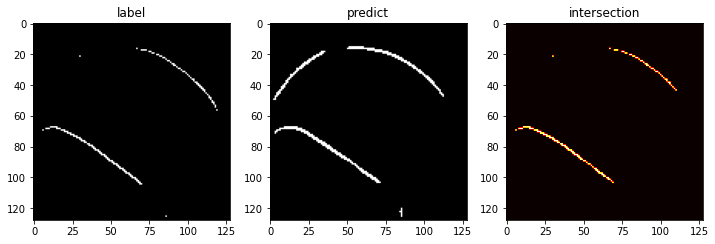

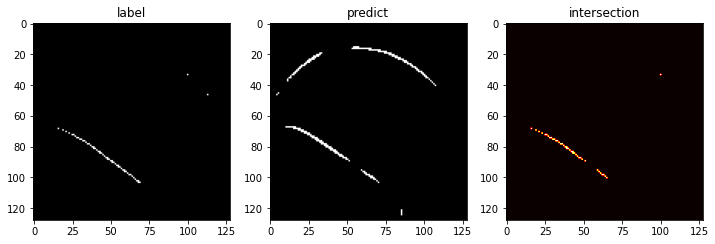

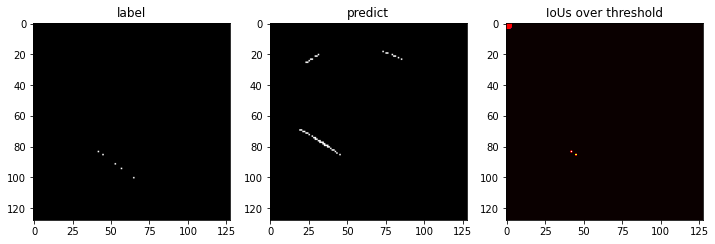

In [10]:
# Evaluation

## model import
model_filepath = "data/models/2020-10-17.h5" # learned by confidence map labels
model2_filepath = "data/models/2020-10-19-semantic-segmentation.h5" # learned by confidence map labels

model = tf.keras.models.load_model(model_filepath)
model2 = tf.keras.models.load_model(model2_filepath)

## test_ds import
element_spec = {
    "image": tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
    "label": tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
    }
test_ds = tf.data.experimental.load("data/datasets/test_ds", element_spec)

thresholds = np.arange(1, 10) * 0.1
results_for_model1 = []
for threshold in thresholds:
  iou = 0
  n = len(test_ds)
  for batch in test_ds:
    y_pred = model.predict(batch['image']) > threshold
    y_true = batch['label'].numpy() > threshold
    v = get_metrics(y_true, y_pred, num_classes=2, metrics='IoU')
    iou += v
  iou /= n
  results_for_model1.append(iou)

results_for_model2 = []
for threshold in thresholds:
  iou = 0
  n = len(test_ds)
  for batch in test_ds:
    y_pred = model2.predict(batch['image']) > threshold
    y_true = batch['label'].numpy() > threshold
    v = get_metrics(y_true, y_pred, num_classes=2, metrics='IoU')
    iou += v
  iou /= n
  results_for_model2.append(iou)



plt.plot(thresholds, results_for_model1, 'bo-')
plt.plot(thresholds, results_for_model2, 'ro-')
plt.title('IoUs over threshold')
plt.plot();


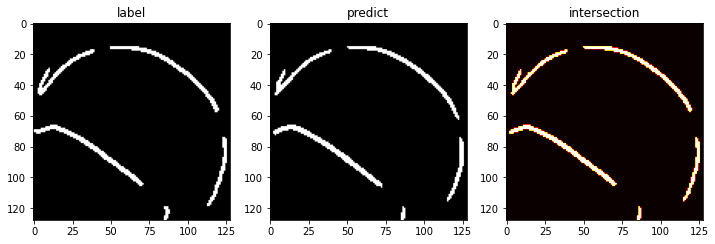